In [ ]:
import os
import librosa
import numpy as np

# --- Config ---
SR = 16000
N_MELS = 64
DURATION = 3  # seconds
SAMPLES = SR * DURATION
CLASS_MAP = {"real": 0, "fake": 1}

# --- 1. Feature Extraction ---
def extract_log_mel(path):
    # Load audio file with specified sample rate
    y, _ = librosa.load(path, sr=SR, mono=True)
    
    # Ensure consistent length
    y = librosa.util.fix_length(y, size=SAMPLES)
    
    # Calculate mel spectrogram - fixed by passing y as a named parameter
    mel_spec = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=N_MELS)
    
    # Convert to log scale (dB)
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    
    return log_mel

# --- 2. Load Dataset into Arrays ---
def load_dataset(split_dir):
    X, y = [], []
    for label in CLASS_MAP:
        class_dir = os.path.join(split_dir, label)
        if not os.path.exists(class_dir):
            continue
        files = [f for f in os.listdir(class_dir) if f.endswith(".wav")]
        for fname in files:
            fpath = os.path.join(class_dir, fname)
            try:
                log_mel = extract_log_mel(fpath)
                X.append(log_mel)
                y.append(CLASS_MAP[label])
            except:
                continue

    X = np.array(X)
    y = np.array(y)

    # Do NOT normalize here
    X = X[..., np.newaxis]
    return X, y

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import librosa
import librosa.display


/Users/madhavgalhotra/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [11]:

def build_model(input_shape):
    """Build a CNN model for audio classification"""
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model


In [12]:
# ---- 3. TRAINING AND EVALUATION ----

def train_model(X_train, y_train, X_val, y_val, model_path='best_model.keras'):
    """Train the model with early stopping and learning rate reduction"""
    input_shape = X_train.shape[1:]
    model = build_model(input_shape)
    
    # Print model summary
    model.summary()
    
    # Callbacks for training
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        ),
        callbacks.ModelCheckpoint(
            filepath=model_path,
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=5,  # We use early stopping, so this is just an upper limit
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks_list,
        verbose=1,
        shuffle=True
    )
    
    return model, history

In [24]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model performance on test set"""
    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate metrics
    test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
    
    # Print results
    print("\n===== Model Evaluation =====")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))
    
    return y_pred, y_pred_prob



In [16]:
np.random.seed(42)
tf.random.set_seed(42)

# 1. Load data
base_path = "./data_preprocessed"
    
print("Loading training data...")
X_train, y_train = load_dataset(os.path.join(base_path, "training"))
print(f"Training set: {X_train.shape}, {y_train.shape}, Class distribution: {np.bincount(y_train)}")

print("\nLoading validation data...")
X_val, y_val = load_dataset(os.path.join(base_path, "validation"))
print(f"Validation set: {X_val.shape}, {y_val.shape}, Class distribution: {np.bincount(y_val)}")

print("\nLoading testing data...")
X_test, y_test = load_dataset(os.path.join(base_path, "testing"))
print(f"Testing set: {X_test.shape}, {y_test.shape}, Class distribution: {np.bincount(y_test)}")


# Compute normalization stats from training set only
mean = np.mean(X_train)
std = np.std(X_train)

# Normalize all splits using train stats
X_train = (X_train - mean) / std
X_val   = (X_val - mean) / std
X_test  = (X_test - mean) / std

Loading training data...
Training set: (48509, 64, 94, 1), (48509,), Class distribution: [24223 24286]

Loading validation data...
Validation set: (10394, 64, 94, 1), (10394,), Class distribution: [5190 5204]

Loading testing data...
Testing set: (10397, 64, 94, 1), (10397,), Class distribution: [5192 5205]


In [17]:
# 2. Train model
print("\nTraining model...")
model, history = train_model(X_train, y_train, X_val, y_val)



Training model...


/Users/madhavgalhotra/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 11, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 11, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,883,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,978,689 (11.36 MB)

 Trainable params: 2,977,729 (11.36 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/5
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 312s 204ms/step - accuracy: 0.9216 - auc: 0.9713 - loss: 0.2076 - val_accuracy: 0.9018 - val_auc: 0.9961 - val_loss: 0.2384 - learning_rate: 1.0000e-04
Epoch 2/5
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 312s 206ms/step - accuracy: 0.9808 - auc: 0.9977 - loss: 0.0543 - val_accuracy: 0.9886 - val_auc: 0.9989 - val_loss: 0.0333 - learning_rate: 1.0000e-04
Epoch 3/5
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 310s 204ms/step - accuracy: 0.9903 - auc: 0.9991 - loss: 0.0295 - val_accuracy: 0.9919 - val_auc: 0.9998 - val_loss: 0.0242 - learning_rate: 1.0000e-04
Epoch 4/5
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 318s 210ms/step - accuracy: 0.9941 - auc: 0.9997 - loss: 0.0184 - val_accuracy: 0.9972 - val_auc: 0.9999 - val_loss: 0.0085 - learning_rate: 1.0000e-04
Epoch 5/5
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 311s 205ms/step - accuracy: 0.9962 - auc: 0.9999 - loss: 0.0114 - val_accuracy: 0.9994 - val_auc: 1.0000 - val_loss: 0.0023 - learning_rate: 1.0000e-04


In [25]:

# 3. Evaluate model
print("\nEvaluating model...")
y_pred, y_pred_prob = evaluate_model(model, X_test, y_test)



Evaluating model...
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step

===== Model Evaluation =====
Test Accuracy: 0.9994
Test AUC: 1.0000
Test Loss: 0.0021

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      5192
        Fake       1.00      1.00      1.00      5205

    accuracy                           1.00     10397
   macro avg       1.00      1.00      1.00     10397
weighted avg       1.00      1.00      1.00     10397



In [26]:
import matplotlib.pyplot as plt
import numpy as np

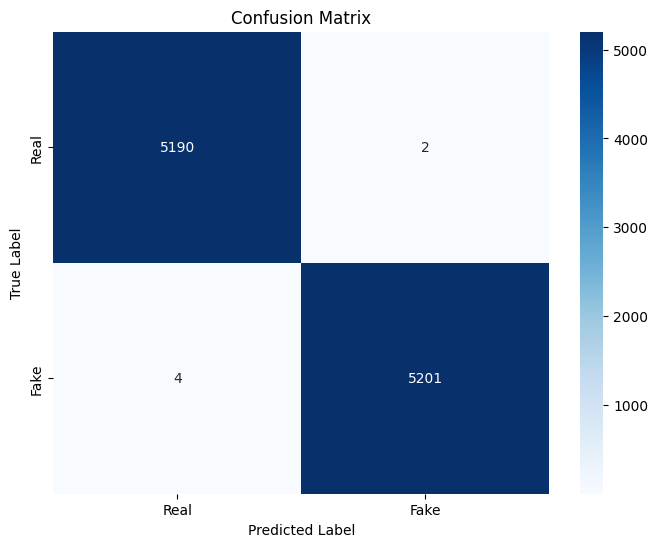

In [29]:
def plot_confusion_matrix(y_true, y_pred, labels):
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Real", "Fake"], 
                yticklabels=["Real", "Fake"])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    plt.savefig('cnn_confusion_matrix.png')
    plt.close()

plot_confusion_matrix(y_test, y_pred, ["Real", "Fake"])


Plotting training history...


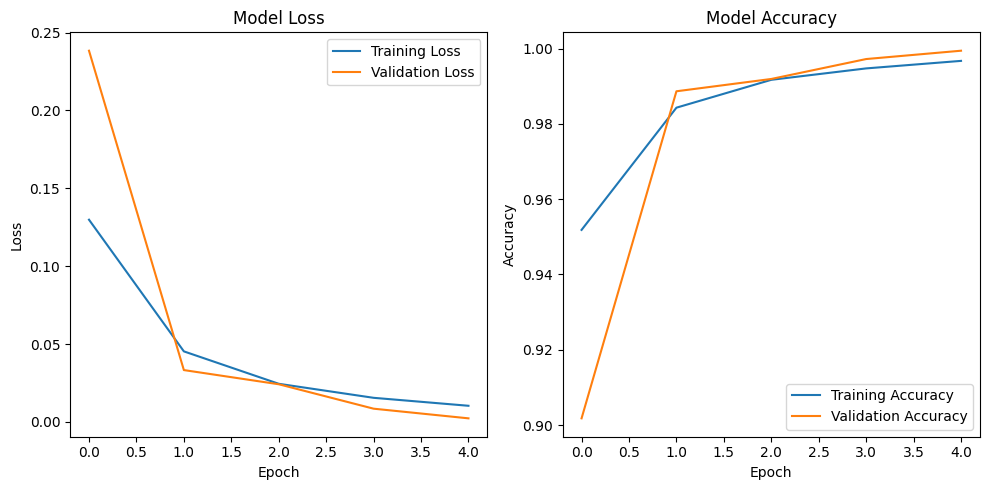

In [30]:
# 1. Plot training history
def plot_training_history(history):
    print("\nPlotting training history...")
    
    # Plot training & validation loss values
    plt.figure(figsize=(10, 5))

    # Plot Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()  # Display the plot
    plt.savefig('CNN_training_history.png')  # Save the plot
    plt.close()  # Close the plot to free memory

# Plot training history
plot_training_history(history)
